##Machine Translation Using a Seq2Seq Architecture
© 2022 Zaka AI, Inc. All Rights Reserved.

---
The goal of this colab is to get you more familiar with the Seq2Seq models and their challenges. For this reason, you will be working on machine translation problem where we would have a sentence as input (in english), and the output is gonna be the translated sentence (in french). So just like what happens with Google Translate.


**Just to give you a heads up:** We won't be having a model performing like Google translate, but at least we will have an idea about how Google Translate works and the challenges that exist with a translation problem.  

## Importing Libraries

We start by importing numpy and pandas and then we can add the rest

In [ ]:
import pandas as pd
import numpy as np
import re
import string #used in removing punctuation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, TimeDistributed, RepeatVector, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from google.colab import files

In [ ]:
!pip install gwpy --quiet
!pip install livelossplot --quiet
from livelossplot import PlotLossesKeras

     |████████████████████████████████| 1.4 MB 28.1 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 
     |████████████████████████████████| 11.2 MB 59.4 MB/s 
     |████████████████████████████████| 51 kB 7.5 MB/s 
     |████████████████████████████████| 4.0 MB 61.6 MB/s 
     |████████████████████████████████| 959 kB 65.4 MB/s 
     |████████████████████████████████| 1.6 MB 51.1 MB/s 


In [ ]:
# # Using PLT Library in general was not working and this solution worked
import matplotlib
if matplotlib.__version__ != '3.1.3' :
  ! pip uninstall matplotlib
  ! pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.5.3
Uninstalling matplotlib-3.5.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.3-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y

  Successfully uninstalled matplotlib-3.5.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 30.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are

We clone the github repository where our data exists. Here is the github link: https://github.com/zaka-ai/machine_learning_certification/tree/main/Challenge%207 

## Getting the data

In [ ]:
df_en = pd.read_csv('https://raw.githubusercontent.com/zaka-ai/machine_learning_certification/main/Challenge%207/en.csv', header = None)
df_fr = pd.read_csv('https://raw.githubusercontent.com/zaka-ai/machine_learning_certification/main/Challenge%207/fr.csv', header = None)

We read the english sentences in a dataframe named "english", and the french sentences in a dataframe named "french"

In [ ]:
#Test Your Zaka (English)
df_en.columns = ['english']
df_en.head()

,english
0,"new jersey is sometimes quiet during autumn , ..."
1,the united states is usually chilly during jul...
2,"california is usually quiet during march , and..."
3,the united states is sometimes mild during jun...
4,"your least liked fruit is the grape , but my l..."


In [ ]:
#Test Your Zaka (French)
df_fr.columns = ['french']
df_fr.head()

,french
0,new jersey est parfois calme pendant l' automn...
1,les états-unis est généralement froid en juill...
2,"california est généralement calme en mars , et..."
3,"les états-unis est parfois légère en juin , et..."
4,"votre moins aimé fruit est le raisin , mais mo..."


**How many sentences does each of the files contain?**

In [ ]:
#Test Your Zaka
print(len(df_en))
len(df_fr)

137860


137860

Now let us concatenate the 2 dataframes into one dataframe that we call **df** where one column has the english senetnces and the other has the french sentences

In [ ]:
#Test Your Zaka
# del df
df = pd.concat([df_en, df_fr], axis = 1)
# df = df.sort_values(by=['english', 'french']).reset_index(drop=True)
df.head()

,english,french
0,"new jersey is sometimes quiet during autumn , ...",new jersey est parfois calme pendant l' automn...
1,the united states is usually chilly during jul...,les états-unis est généralement froid en juill...
2,"california is usually quiet during march , and...","california est généralement calme en mars , et..."
3,the united states is sometimes mild during jun...,"les états-unis est parfois légère en juin , et..."
4,"your least liked fruit is the grape , but my l...","votre moins aimé fruit est le raisin , mais mo..."


Let's name the columns as **English** and **French** so that we access them easier.

In [ ]:
#Test Your Zaka
#DONE

Pick a sentence and print it in both languages

In [ ]:
#Test Your Zaka
print(f'English: {df.english[1]}')
print(f'French {df.french[1]}')

English: the united states is usually chilly during july , and it is usually freezing in november .
French les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .


##Cleaning Data

The data that we have is almost clean as we can see, we just need to remove the punctuations inside of it.

In [ ]:
df.english = df.english.apply(lambda x : re.sub(r'[^a-z]', ' ', x))
french_test = df.french.apply(lambda x : re.sub(r'[^a-z]', ' ', x))
#Test Your Zaka
print(f'English: {df.english[1]}')
print(f'French {french_test[1]}')

English: the united states is usually chilly during july   and it is usually freezing in november  
French les  tats unis est g n ralement froid en juillet   et il g le habituellement en novembre  


It was successful on the english text but **didnt** work with the **french** sentence. As we can notice, letters with special characters such as the acute **accent** é etc are removed. Thus, we used **string** library.

In [ ]:
print(string.punctuation)
t=[]
sen = []
for sentence in df.french:
  for word in sentence.split():
    sen.append(''.join( word.strip(string.punctuation)))
  t.append(' '.join(sen))
  sen = []
df.french = t

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


Make sure that the punctuation is removed by printing the example that you printed earlier.

In [ ]:
#Test Your Zaka
print(f'English: {df.english[1]}')
print(f'French {df.french[1]}')

English: the united states is usually chilly during july   and it is usually freezing in november  
French les états-unis est généralement froid en juillet  et il gèle habituellement en novembre 


##Exploring the Data

Add a column **ENG Length** to the dataset that shows how many words does a sentence contain, and do the same for french in a column called **FR Length**

In [ ]:
#Test Your Zaka
df['eng_length'] = df.english.apply(lambda x : len(x.split()))
df['fr_length'] = df.french.apply(lambda x : len(x.split()))
df

,english,french,eng_length,fr_length
0,new jersey is sometimes quiet during autumn ...,new jersey est parfois calme pendant l automne...,13,14
1,the united states is usually chilly during jul...,les états-unis est généralement froid en juill...,15,13
2,california is usually quiet during march and...,california est généralement calme en mars et ...,13,13
3,the united states is sometimes mild during jun...,les états-unis est parfois légère en juin et ...,14,13
4,your least liked fruit is the grape but my l...,votre moins aimé fruit est le raisin mais mon...,14,14
...,...,...,...,...
137855,france is never busy during march and it is ...,la france est jamais occupée en mars et il es...,13,14
137856,india is sometimes beautiful during spring a...,l inde est parfois belle au printemps et il e...,12,13
137857,india is never wet during summer but it is s...,l inde est jamais mouillé pendant l été mais ...,13,15
137858,france is never chilly during january but it...,la france est jamais froid en janvier mais il...,13,14


Visualize the distribution of the lengths of english sentences and french sentences.

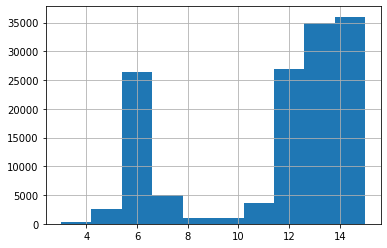

In [ ]:
#Test Your Zaka
df.eng_length.hist()

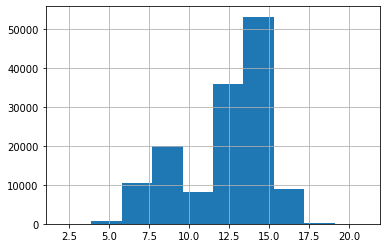

In [ ]:
#Test Your Zaka
df.fr_length.hist()

Get the maximum length of an english sentence and the maximum length of a french sentence. 

In [ ]:
#Test Your Zaka
print(f'Max len of eng sentence : {max(df.eng_length)} and max in fr is : {max(df.fr_length)}')

Max len of eng sentence : 15 and max in fr is : 21


##Preprocessing the Data

In order for the data to be fed to the model, it has to be tokenized and padded. 

####Tokenization

**To tokenize english and french sentences, we can use only one tokenizer. True or False?**

One us not suitable for both languages as wach one differs than the other in many things such as stopwords etc and both languages has different words.

Tokenize the sentences that we have.

In [ ]:
#Test Your Zaka

# define your tokenizer
tokenizer_eng = Tokenizer()
tokenizer_fr = Tokenizer()

# assign an index (number) to each word using fit_on_texts function
tokenizer_eng.fit_on_texts(df.english)
tokenizer_fr.fit_on_texts(df.french)

# transform each text to a sequence of integers (to be used later in embeddings layer)
eng_token =  tokenizer_eng.texts_to_sequences(df.english)
fr_token =  tokenizer_fr.texts_to_sequences(df.french)

In [ ]:
#Testing
print(tokenizer_eng.word_index)
eng_token[1]

{'is': 1, 'in': 2, 'it': 3, 'during': 4, 'the': 5, 'but': 6, 'and': 7, 'sometimes': 8, 'usually': 9, 'never': 10, 'favorite': 11, 'least': 12, 'fruit': 13, 'most': 14, 'loved': 15, 'liked': 16, 'new': 17, 'paris': 18, 'india': 19, 'united': 20, 'states': 21, 'california': 22, 'jersey': 23, 'france': 24, 'china': 25, 'he': 26, 'she': 27, 'grapefruit': 28, 'your': 29, 'my': 30, 'his': 31, 'her': 32, 'fall': 33, 'june': 34, 'spring': 35, 'january': 36, 'winter': 37, 'march': 38, 'autumn': 39, 'may': 40, 'nice': 41, 'september': 42, 'july': 43, 'april': 44, 'november': 45, 'summer': 46, 'december': 47, 'february': 48, 'our': 49, 'their': 50, 'freezing': 51, 'pleasant': 52, 'beautiful': 53, 'october': 54, 'snowy': 55, 'warm': 56, 'cold': 57, 'wonderful': 58, 'dry': 59, 'busy': 60, 'august': 61, 'chilly': 62, 'rainy': 63, 'mild': 64, 'wet': 65, 'relaxing': 66, 'quiet': 67, 'hot': 68, 'dislikes': 69, 'likes': 70, 'limes': 71, 'lemons': 72, 'grapes': 73, 'mangoes': 74, 'apples': 75, 'peaches':

[5, 20, 21, 1, 9, 62, 4, 43, 7, 3, 1, 9, 51, 2, 45]

**How many unique words do we have in english and in french?**

In [ ]:
#Test Your Zaka
print(f'There are {len(tokenizer_eng.word_index)} unique eng words and {len(tokenizer_fr.word_index)} unique fr words')

There are 200 unique eng words and 344 unique fr words


####Padding

**What should be the length of the sequences that we have after padding?**

It is based on the longest sentence we have in both languages which is 15 in English and 21 in French

Perform padding on the sequences that we have.

In [ ]:
#Test Your Zaka

# apply post-padding to the sequences
eng_max_length = max(df.eng_length)
fr_max_length = max(df.fr_length)

eng_pad = pad_sequences(eng_token, maxlen=eng_max_length, padding='post')
fr_pad = pad_sequences(fr_token, maxlen=fr_max_length, padding='post')

In [ ]:
print(fr_pad[1])
fr_pad[2]

[ 4 32 31  1 12 19  2 49  6  3 95 69  2 51  0  0  0  0  0  0  0]


array([101,   1,  12,  67,   2,  45,   6,   3,   1,  12,  21,   2,  41,
         0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

##Modeling

After preprrocessing the data, we can build our model. Start by building a baseline architecture relying on one directional RNNs, LSTMs, or GRUs. It will be good to lookup how to build Seq2Seq models, there are some new layers that will help you like RepeatVector and TimeDistributed.

In [ ]:
eng_vocab_size = len(tokenizer_eng.word_index) + 1
fr_vocab_size = len(tokenizer_fr.word_index) + 1
embedding_dim = 256
hidden_size = 1024 # Just for testing purposes but not good idea for now to have a big number as the model size could go from few KBs to 100 MBs easily

In [ ]:
# FILL BLANKS
# build the neural network
model = Sequential()

model.add(Embedding(eng_vocab_size, embedding_dim, input_length=eng_max_length))

model.add(LSTM(hidden_size))
model.add(RepeatVector(fr_max_length))

model.add(LSTM(hidden_size, return_sequences=True))
model.add(TimeDistributed(Dense(fr_vocab_size, activation='softmax')))

# THere is an error : when we use categorical_crossentropy
# Solutions: either use the sparse loss function or do one hot encoding to the input data
# the one hot encoding is sparse representation but it is used just when inputting data to the embedding layer thus we keep the dense representation
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 256)           51456     
                                                                 
 lstm (LSTM)                 (None, 1024)              5246976   
                                                                 
 repeat_vector (RepeatVector  (None, 21, 1024)         0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 21, 1024)          8392704   
                                                                 
 time_distributed (TimeDistr  (None, 21, 345)          353625    
 ibuted)                                                         
                                                                 
Total params: 14,044,761
Trainable params: 14,044,761
No

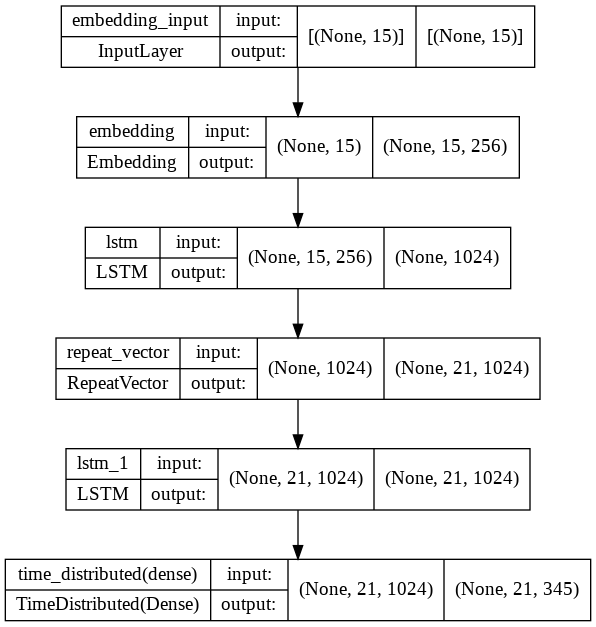

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
eng_pad.shape, fr_pad.shape, eng_vocab_size, fr_vocab_size, eng_max_length, fr_max_length

((137860, 15), (137860, 21), 201, 345, 15, 21)

Compile and train the model. 
**FYI:** While specifying the architecture of your model and the number of epochs for training, keeep in your mind that your model might take A LOT of time to train.

We tested several Models which are:
- Model1 = normal LSTM
- Model2 = 2x Bi LSTM
- Model3 = 1x Bi LSTM
- Model4 = 1x Bi LSTM + data splitting
- Model5 = Stacking BiLSTMs


# **Model1 = normal LSTM**

In [ ]:
# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

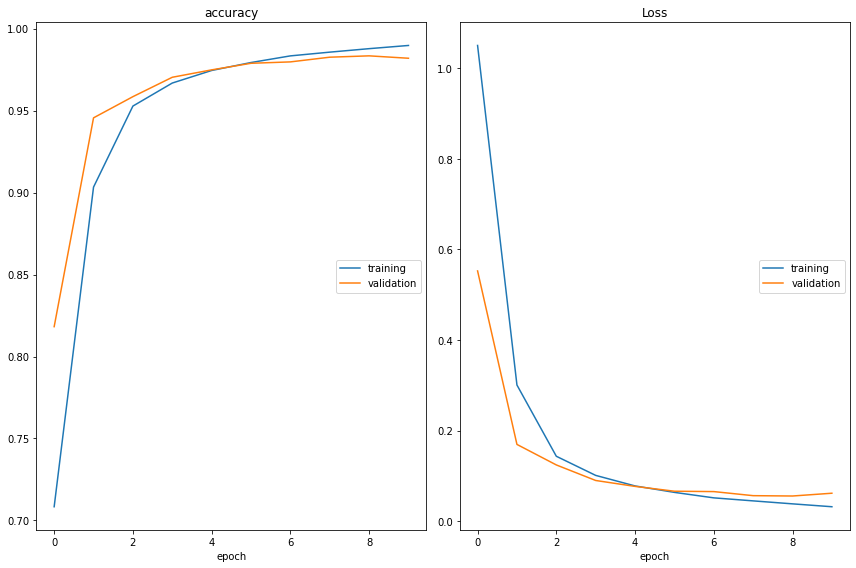

accuracy
	training         	 (min:    0.708, max:    0.990, cur:    0.990)
	validation       	 (min:    0.818, max:    0.983, cur:    0.982)
Loss
	training         	 (min:    0.032, max:    1.050, cur:    0.032)
	validation       	 (min:    0.055, max:    0.552, cur:    0.062)
1831/1831 [==============================] - 73s 40ms/step - loss: 0.0318 - accuracy: 0.9897 - val_loss: 0.0616 - val_accuracy: 0.9819


In [ ]:
#Test Your Zaka
model.fit(x = eng_pad, y = fr_pad, batch_size = 64, epochs=10, validation_split=0.15, callbacks=[PlotLossesKeras(), early_stop])

In [ ]:
# Saving the model to avoid training it again due to runtime reset:
!mkdir -p saved_model

In [ ]:
# Naming convention: translation_'model architecture used'_'loss'_'acc'
model.save('saved_model/translation_LSTM_0.0375_0.9881.h5') 

In [ ]:
#Load the model:
new_model = tf.keras.models.load_model('/content/saved_model/translation_LSTM_0.0375_0.9881.h5')

# Check its architecture
new_model.summary()

In [ ]:
files.download('saved_model/translation_LSTM_0.0375_0.9881.h5') 

Define a function that gets an input sentence in english and gives the output sentence in the french language.

In [ ]:
#Test Your Zaka
def translate(eng_sentence):
  print(eng_sentence)
  
  # transform each text to a sequence of integers (to be used later in embeddings layer)
  # This line "sentence_token =  tokenizer_eng.texts_to_sequences(eng_sentence)" didnt work as it apply tokenization to each word or letter in the string  
  # (Based on the documentation it takes each text in texts, so it seems that it considered the input string as texts and divides it )
  # As a result, converting the string to a list [] takes the full string as 1 sentence 
  sentence_token =  tokenizer_eng.texts_to_sequences([eng_sentence])
  # print(sentence_token) # [[27, 1, 107, 5, 101]]

  sentence_pad = pad_sequences(sentence_token, maxlen=eng_max_length, padding='post')

  prediction = model.predict(sentence_pad)
  
  prediction.shape # (1, 21, 345) = output of the Decoder
  translated_words = np.argmax(prediction, axis = 2) # argmax across axis 2 gives us (21, 345) where we have 21 max length sentence and 345 possible word
  no_zero = [i for i in translated_words[0] if i != 0] # removing zeros
  
  translated_sentence = [list(tokenizer_fr.word_index)[word - 1] for word in no_zero]
  
  translated_sentence = ' '.join(translated_sentence)
  return translated_sentence

Test the following sentence

In [ ]:
input = "she is driving the truck"
print(input)

# # A working method to pass the input sentence to tokenizer_eng.texts_to_sequences() directly without using [] brackets
# from io import StringIO
# t = pd.read_csv(StringIO(input), header = None)
# t.columns = ['eng']
# t.head()
# # print(df.english[1])
#Test Your Zaka
# translate(t.eng)

prediction = translate(input)
prediction

she is driving the truck
she is driving the truck


'elle conduit le le lac'

Try to improve your model by modifying the architecture to take into account bidirectionality which is very useful in Machine Translation. Create a new model called model2

# **Model2 = 2x Bidirectional LSTM**

In [ ]:
#Test Your Zaka
embedding_dim = 256

model2 = Sequential()
model2.add(Embedding(eng_vocab_size, embedding_dim, input_length=eng_max_length))
model2.add(Bidirectional(LSTM(hidden_size)))
model2.add(RepeatVector(fr_max_length))
model2.add(Bidirectional(LSTM(hidden_size, return_sequences=True)))
model2.add(TimeDistributed(Dense(fr_vocab_size, activation='softmax')))

model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 256)           51456     
                                                                 
 bidirectional (Bidirectiona  (None, 2048)             10493952  
 l)                                                              
                                                                 
 repeat_vector (RepeatVector  (None, 21, 2048)         0         
 )                                                               
                                                                 
 bidirectional_1 (Bidirectio  (None, 21, 2048)         25174016  
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 21, 345)          706905    
 ibuted)                                                

compile and train your new model.

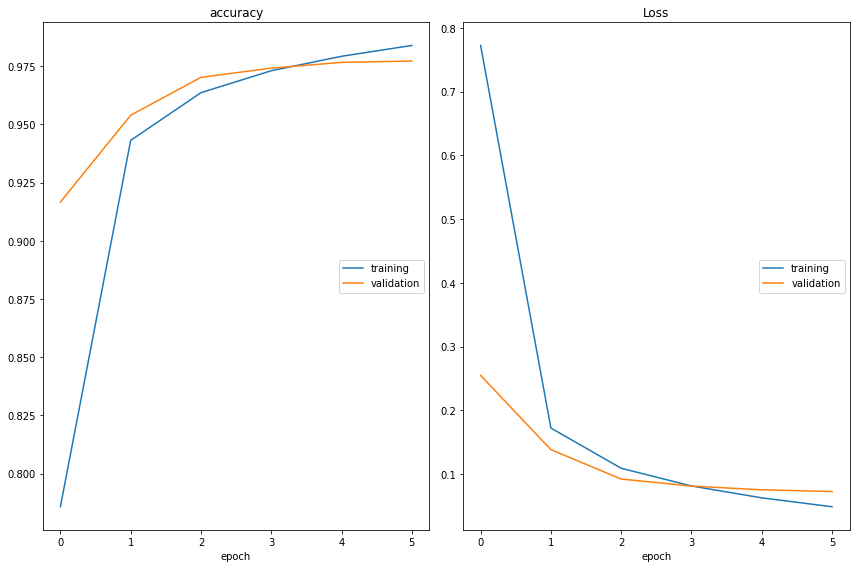

accuracy
	training         	 (min:    0.786, max:    0.984, cur:    0.984)
	validation       	 (min:    0.917, max:    0.977, cur:    0.977)
Loss
	training         	 (min:    0.049, max:    0.772, cur:    0.049)
	validation       	 (min:    0.073, max:    0.255, cur:    0.073)
1724/1724 [==============================] - 177s 103ms/step - loss: 0.0490 - accuracy: 0.9839 - val_loss: 0.0727 - val_accuracy: 0.9772


In [ ]:
#Test Your Zaka
model2.fit(x = eng_pad, y = fr_pad, batch_size = 64, epochs=6, validation_split=0.20, callbacks=[PlotLossesKeras(), early_stop])

In [ ]:
def download(model_type, loss, acc):
  string = f'saved_model/{model_type}.{loss}.{acc}.h5'
  # Saving the model to avoid training it again due to runtime reset:
  !mkdir -p saved_model
  # Naming convention: translation_'model architecture used'_'loss'_'acc'
  model.save(string) 
  files.download(string) 

In [ ]:
download('2BiLSTM','0.049','0.984')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Define a new function that relies on your new model to make predictions.

In [ ]:
#Test Your Zaka
# We just change the model name
def translate(model99, eng_sentence = "she is driving the truck"):
  
  # transform each text to a sequence of integers (to be used later in embeddings layer)
  # This line "sentence_token =  tokenizer_eng.texts_to_sequences(eng_sentence)" didnt work as it apply tokenization to each word or letter in the string  
  # (Based on the documentation it takes each text in texts, so it seems that it considered the input string as texts and divides it )
  # As a result, converting the string to a list [] takes the full string as 1 sentence 
  sentence_token =  tokenizer_eng.texts_to_sequences([eng_sentence])
  # print(sentence_token) # [[27, 1, 107, 5, 101]]

  sentence_pad = pad_sequences(sentence_token, maxlen=eng_max_length, padding='post')

  prediction = model99.predict(sentence_pad)
  
  prediction.shape # (1, 21, 345) = output of the Decoder
  translated_words = np.argmax(prediction, axis = 2) # argmax across axis 2 gives us (21, 345) where we have 21 max length sentence and 345 possible word
  no_zero = [i for i in translated_words[0] if i != 0] # removing zeros
  
  translated_sentence = [list(tokenizer_fr.word_index)[word - 1] for word in no_zero]
  
  translated_sentence = ' '.join(translated_sentence)
  return translated_sentence

In [ ]:
input = "she is driving the truck"
#Test Your Zaka
translate(input, model2)

'elle conduit le camion camion'

**Testing with only a Bidirectional layer in the encoder:**

# **Model3 = 1x Bi LSTM**

In [ ]:
#Test Your Zaka
embedding_dim = 256

model3 = Sequential()
model3.add(Embedding(eng_vocab_size, embedding_dim, input_length=eng_max_length))
model3.add(Bidirectional(LSTM(hidden_size)))
model3.add(RepeatVector(fr_max_length))
model3.add(LSTM(hidden_size, return_sequences=True))
model3.add(TimeDistributed(Dense(fr_vocab_size, activation='softmax')))

model3.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 15, 256)           51456     
                                                                 
 bidirectional_7 (Bidirectio  (None, 2048)             10493952  
 nal)                                                            
                                                                 
 repeat_vector_5 (RepeatVect  (None, 21, 2048)         0         
 or)                                                             
                                                                 
 lstm_11 (LSTM)              (None, 21, 1024)          12587008  
                                                                 
 time_distributed_5 (TimeDis  (None, 21, 345)          353625    
 tributed)                                                       
                                                      

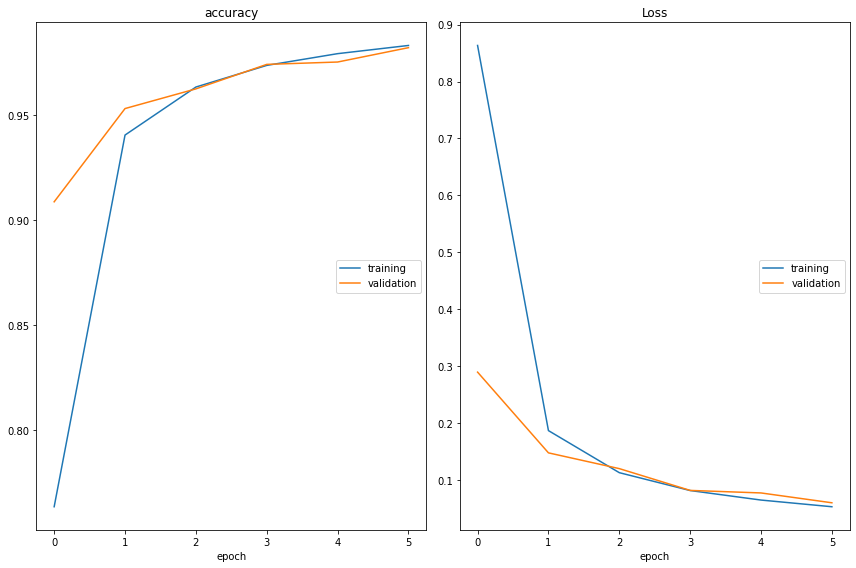

accuracy
	training         	 (min:    0.763, max:    0.983, cur:    0.983)
	validation       	 (min:    0.909, max:    0.982, cur:    0.982)
Loss
	training         	 (min:    0.053, max:    0.863, cur:    0.053)
	validation       	 (min:    0.060, max:    0.290, cur:    0.060)
1724/1724 [==============================] - 115s 67ms/step - loss: 0.0531 - accuracy: 0.9830 - val_loss: 0.0600 - val_accuracy: 0.9820


In [ ]:
#Test Your Zaka
model3.fit(x = eng_pad, y = fr_pad, batch_size = 64, epochs=6, validation_split=0.20, callbacks=[PlotLossesKeras(), early_stop])

In [ ]:
download('1BiLSTM','0.053','0.983')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
translate(input, model3)

'elle conduit le nouveau camion'

# **Model4 = 1x Bi LSTM + data splitting**

In [ ]:
from sklearn.model_selection import train_test_split
X = df['english']
y = df['french']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(96502,) (96502,)
(41358,) (41358,)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# define your tokenizer (with num_words=10000)
tokenizer_eng = Tokenizer(num_words=1000)
tokenizer_fr = Tokenizer(num_words=1000)

# assign an index (number) to each word using fit_on_texts function  
tokenizer_eng.fit_on_texts(x_train)
tokenizer_fr.fit_on_texts(y_train)

# will be used later to pad sequences
eng_max_length = max(df.eng_length)
fr_max_length = max(df.fr_length)

# define vocabulary size
vocab_size_en = len(tokenizer_eng.word_index) + 1
vocab_size_fr = len(tokenizer_fr.word_index) + 1

# transform each text to a sequence of integers (to be used later in embeddings layer)
X_train_tokens =  tokenizer_eng.texts_to_sequences(x_train)
X_test_tokens = tokenizer_eng.texts_to_sequences(x_test)

y_train_tokens =  tokenizer_fr.texts_to_sequences(y_train)
y_test_tokens = tokenizer_fr.texts_to_sequences(y_test)

# apply post-padding to the sequences
X_train_pad = pad_sequences(X_train_tokens, maxlen=eng_max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=eng_max_length, padding='post')

y_train_pad = pad_sequences(y_train_tokens, maxlen=fr_max_length, padding='post')
y_test_pad = pad_sequences(y_test_tokens, maxlen=fr_max_length, padding='post')

In [ ]:
print(X_train_pad.shape)
print(y_train_pad.shape)
print(X_test_pad.shape)
print(y_test_pad.shape)

(110288, 21)
(110288, 21)
(27572, 21)
(27572, 21)


In [ ]:
model4 = Sequential()

model4.add(Embedding(vocab_size_en, embedding_dim, input_length=eng_max_length))

model4.add(LSTM(hidden_size))
model4.add(RepeatVector(fr_max_length))
model4.add(LSTM(hidden_size, return_sequences=True))
model4.add(Dense(32, activation='relu'))
model4.add(TimeDistributed(Dense(vocab_size_fr, activation='softmax')))
model4.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model4.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 15, 300)           60300     
                                                                 
 lstm_36 (LSTM)              (None, 75)                112800    
                                                                 
 repeat_vector_14 (RepeatVec  (None, 21, 75)           0         
 tor)                                                            
                                                                 
 lstm_37 (LSTM)              (None, 21, 75)            45300     
                                                                 
 dense_15 (Dense)            (None, 21, 32)            2432      
                                                                 
 time_distributed_14 (TimeDi  (None, 21, 343)          11319     
 stributed)                                          

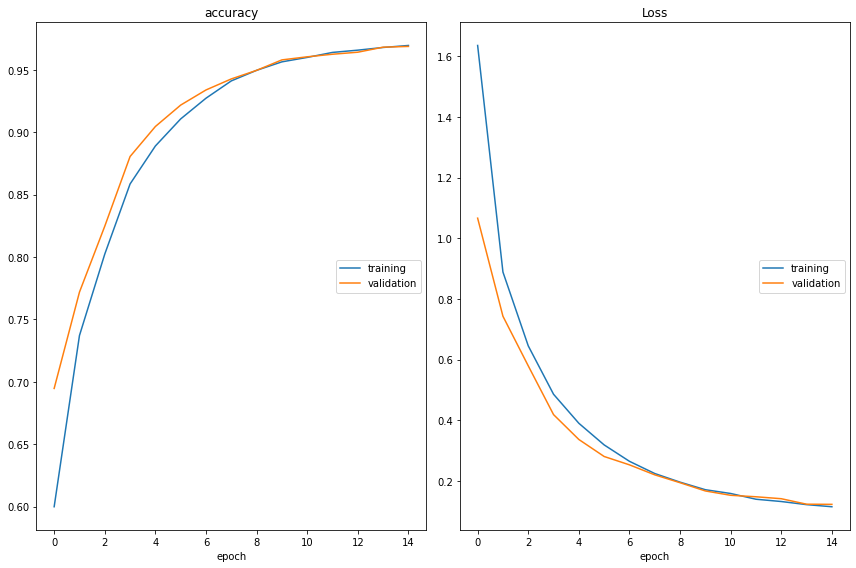

accuracy
	training         	 (min:    0.600, max:    0.970, cur:    0.970)
	validation       	 (min:    0.695, max:    0.969, cur:    0.969)
Loss
	training         	 (min:    0.115, max:    1.635, cur:    0.115)
	validation       	 (min:    0.123, max:    1.066, cur:    0.123)
3447/3447 [==============================] - 34s 10ms/step - loss: 0.1153 - accuracy: 0.9696 - val_loss: 0.1231 - val_accuracy: 0.9688


In [ ]:
model4.fit(X_train_pad, y_train_pad, batch_size=32, epochs=15, validation_data=(X_test_pad, y_test_pad), callbacks=[PlotLossesKeras()])

In [ ]:
input = "she is driving the truck"
#Test Your Zaka
prediction = translate(input, model4)
prediction

'elle conduit le camion camion blanc'

# **Model5 = Stacking BiLSTMs**

In [ ]:
#Test Your Zaka
embedding_dim = 128

model5 = Sequential()
model5.add(Embedding(eng_vocab_size, embedding_dim, input_length=eng_max_length))
model5.add(Bidirectional(LSTM(hidden_size, return_sequences=True)))
model5.add(Bidirectional(LSTM(hidden_size)))
model5.add(RepeatVector(fr_max_length))
model5.add(Bidirectional(LSTM(hidden_size, return_sequences=True)))
model5.add(Bidirectional(LSTM(hidden_size, return_sequences=True)))
model5.add(TimeDistributed(Dense(fr_vocab_size, activation='softmax')))

model5.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 15, 128)           25728     
                                                                 
 bidirectional_4 (Bidirectio  (None, 15, 2048)         9445376   
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 2048)             25174016  
 nal)                                                            
                                                                 
 repeat_vector_1 (RepeatVect  (None, 21, 2048)         0         
 or)                                                             
                                                                 
 bidirectional_6 (Bidirectio  (None, 21, 2048)         25174016  
 nal)                                                 

In [ ]:
#Test Your Zaka
model5.fit(x = eng_pad, y = fr_pad, batch_size = 64, epochs=6, validation_split=0.20, callbacks=[PlotLossesKeras(), early_stop])

Epoch 1/6
 331/1724 [====>.........................] - ETA: 8:23:40 - loss: 1.8862 - accuracy: 0.5541

In [ ]:
download('1BiLSTM','0.053','0.983')

In [ ]:
translate(model5)

'elle conduit le petit camion noir'

# Models Comparison:
- Model1 = normal LSTM                     |  **elle conduit le le lac**
- Model2 = 2x Bi LSTM               | **elle conduit le camion camion**
- Model3 = 1x Bi LSTM                  |  **elle conduit le nouveau camion**
- Model4 = 1x Bi LSTM + data splitting                          | **elle conduit le camion camion blanc**
- Model5 = Stacking BiLSTMs | **elle conduit le petit camion noir**

Note: It seems like the models predict the main words but it prints with it an adjective such as nouveau ot blanc.  

**What is another adjustment in terms of architecture that you might be able to do to improve your model?**

- Attention (or using Transformers)
- Using GRU may have a better performance than LSTM 


**What are some additional ways that we can do to improve the performance of our model?**

- Splitting data for training and testing 
- More data cleaning. Maybe removing stopwatch, keep the ' in the french language and other things that may help improving the input data
- Playing with the Deep Layers number
- More epoch as we can see that there is a rising trend for the model

# **Testing Attention**

In [ ]:
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Concatenate
from tensorflow.keras import Input, Model

# Encoder input
encoder_inputs = Input(shape=(eng_max_length,)) 

# Embedding layer- i am using 1024 output-dim for embedding you can try diff values 100,256,512,1000
enc_emb = Embedding(eng_vocab_size, 1024)(encoder_inputs)

# Bidirectional lstm layer
enc_lstm1 = Bidirectional(LSTM(256,return_sequences=True,return_state=True))
encoder_outputs1, forw_state_h, forw_state_c, back_state_h, back_state_c = enc_lstm1(enc_emb)

# Concatenate both h and c 
final_enc_h = Concatenate()([forw_state_h,back_state_h])
final_enc_c = Concatenate()([forw_state_c,back_state_c])

# get Context vector
encoder_states =[final_enc_h, final_enc_c]

In [ ]:
from tensorflow.keras.layers import Attention
#  decoder input
decoder_inputs = Input(shape=(None,)) 

# decoder embedding with same number as encoder embedding
dec_emb_layer = Embedding(fr_vocab_size, 1024) 
dec_emb = dec_emb_layer(decoder_inputs)   # apply this way because we need embedding layer for prediction 

# In encoder we used Bidirectional so it's having two LSTM's so we have to take double units(256*2=512) for single decoder lstm
# LSTM using encoder's final states as initial state
decoder_lstm = LSTM(512, return_sequences=True, return_state=True) 
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Using Attention Layer
attention_layer = AttentionLayer()
attention_result = attention_layer([encoder_outputs1, decoder_outputs])

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_result])

# Dense layer with softmax
decoder_dense = Dense(fr_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)
dropout = Dropout(rate=0.20)
decoder_outputs = dropout(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 

In [ ]:
# ***IMP note :- if loss categorical crossentropy used then shapes incompatible error will occcur beause 
# we have to use sparse_categorical_crossentropy when we have all different labels categorical is for mutliclass labels***

# compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Define callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("give Your path to save check points", monitor='val_accuracy')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
callbacks_list = [checkpoint, early_stopping]

# Training set
encoder_input_data = X_train_pad
# To make same as target data skip last number which is just padding
decoder_input_data = y_train_pad[:,:-1]
# Decoder target data has to be one step ahead so we are taking from 1 as told in keras docs
decoder_target_data =  y_train_pad[:,1:]

# devlopment set
encoder_input_test = X_test_pad
decoder_input_test = y_test_pad[:,:-1]
decoder_target_test=  y_test_pad[:,1:]

EPOCHS= 4 #@param {type:'slider',min:0,max:10, step:1}
history = model.fit([encoder_input_data, decoder_input_data],decoder_target_data, 
                    epochs=EPOCHS, 
                    batch_size=128,
                    validation_data = ([encoder_input_test, decoder_input_test],decoder_target_test),
                    callbacks= callbacks_list)

Epoch 1/4
753/754 [============================>.] - ETA: 0s - loss: 2.1674 - accuracy: 0.6833

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


754/754 [==============================] - 56s 66ms/step - loss: 2.1664 - accuracy: 0.6834 - val_loss: 0.1123 - val_accuracy: 0.9735
Epoch 2/4
754/754 [==============================] - ETA: 0s - loss: 1.3081 - accuracy: 0.7894

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


754/754 [==============================] - 48s 64ms/step - loss: 1.3081 - accuracy: 0.7894 - val_loss: 0.0553 - val_accuracy: 0.9893
Epoch 3/4
753/754 [============================>.] - ETA: 0s - loss: 1.2485 - accuracy: 0.7935

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


754/754 [==============================] - 48s 63ms/step - loss: 1.2484 - accuracy: 0.7935 - val_loss: 0.0425 - val_accuracy: 0.9927
Epoch 4/4
754/754 [==============================] - ETA: 0s - loss: 1.2268 - accuracy: 0.7954

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


754/754 [==============================] - 47s 63ms/step - loss: 1.2268 - accuracy: 0.7954 - val_loss: 0.0386 - val_accuracy: 0.9938


In [ ]:
# INFERENCE MODEL
# encoder Inference model
encoder_model = Model(encoder_inputs, outputs = [encoder_outputs1, final_enc_h, final_enc_c])

# Decoder Inference
decoder_state_h = Input(shape=(512,)) # This numbers has to be same as units of lstm's on which model is trained
decoder_state_c = Input(shape=(512,))

# we need hidden state for attention layer
# 36 is maximum length if english sentence It has to same as input taken by attention layer can see in model plot
decoder_hidden_state_input = Input(shape=(15,512)) 
# get decoder states
dec_states = [decoder_state_h, decoder_state_c]

# embedding layer 
dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=dec_states)

# Attention inference
attention_result_inf = attention_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_concat_input_inf = Concatenate(axis=-1, name='concat_layer')([decoder_outputs2, attention_result_inf])

dec_states2= [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_concat_input_inf)

# get decoder model
decoder_model= Model(
                    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_h, decoder_state_c],
                     [decoder_outputs2]+ dec_states2)

In [ ]:
def get_predicted_sentence(input_seq):
    # Encode the input as state vectors.
    enc_output, enc_h, enc_c = encoder_model.predict(input_seq)
  
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first character of target sequence with the start character.
    # target_seq[0, 0] = mar_word_index['sos']
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [enc_output, enc_h, enc_c ])
        
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # print(f'sampled_token_index {sampled_token_index}')
        if sampled_token_index == 0:
          break
        # convert max index number to marathi word
        sampled_char = fr_index_word[sampled_token_index]
        # print(f'sampled_char: {sampled_char}')
        # aapend it to decoded sent
        decoded_sentence += ' '+sampled_char
        # print(f'decoded_sentence: {decoded_sentence}')

        # Exit condition: either hit max length or find stop token.
        if (sampled_char == 'eos' or len(decoded_sentence.split()) >= vocab_size_fr):
            stop_condition = True
        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # Update states
        enc_h, enc_c = h, c
    
    return decoded_sentence

In [ ]:
# English Word --> index dictionary
eng_index_word = tokenizer_eng.index_word
eng_word_index = tokenizer_eng.word_index
# French Index --> word dict
fr_index_word = tokenizer_fr.index_word
fr_word_index = tokenizer_fr.word_index
# we need actual French sentence so crate fuction to convert back tokens into words
def get_French_sentence(input_sequence):
    sentence =''
    for i in input_sequence:
      if i!=0 :
        sentence =sentence +fr_index_word[i]+' '
    return sentence 

# same as above we want input english sentence so create function
def get_english_sentence(input_sequence):
    sentence =''
    for i in input_sequence:
      if i!=0:
        sentence =sentence +eng_index_word[i]+' '
    return sentence     

# using simple loop we will take 15 random numbers from x_test and get results
for i in np.random.randint(10, 1000, size=15):
  print("English Sentence:",get_english_sentence(X_test_pad[i]))
  print("Actual French Sentence:",get_French_sentence(y_test_pad[i])[4:-4])
  # Before passing input it has to be reshape as following
  print("Predicted French Translation:",get_predicted_sentence(X_test_pad[i].reshape(1,eng_max_length))[:-4])
  print("----------------------------------------------------------------------------------------")
   

English Sentence: his least liked fruit is the peach but my least liked is the orange 
Actual French Sentence: fruit est moins aimé la pêche mais mon moins aimé est l'ora
Predicted French Translation:  moins aimé est la pêche mais mon moins aimé est l'or
----------------------------------------------------------------------------------------
English Sentence: the orange is your most loved fruit but the peach is her most loved 
Actual French Sentence: ange est votre fruit le plus aimé mais la pêche est la plus ai
Predicted French Translation:  est votre fruit le plus aimé mais la pêche elle est le plus 
----------------------------------------------------------------------------------------
English Sentence: new jersey is usually chilly during march but it is sometimes freezing in fall 
Actual French Sentence: jersey est généralement froid en mars mais il est parfois le gel à l auto
Predicted French Translation:  est généralement froid en mars mais il est parfois le gel à l aut
--------

In [ ]:
get_predicted_sentence(X_test_pad[0].reshape(1,eng_max_length))

' est généralement occupé en septembre mais il est parfois froid au printemps'

In [ ]:
pred = pd.DataFrame(["she is driving the truck"], columns=['sen_to_pred'])
p = pred['sen_to_pred']
p_tk = tokenizer_eng.texts_to_sequences(p)
p_pad = pad_sequences(p_tk, maxlen=eng_max_length, padding='post')
get_predicted_sentence(p_pad[0].reshape(1,eng_max_length))

' le camion rouge'

It is not translating well words that are new. We dont know yet what is the main problem. It may be overfit as it reached more than 90% acc in the second epoch only as acc is not a reliable metric for NLP appications. To solve it a bit we introduced a Dropout Layer. (When we added the droupout, we used a rate of 0.3, the learning became so slow so we reduced it)

Maybe using Teacher Forcing would sldo help the training.

We noticed that the validation accuracy is much higher than the training accuracy.

At least we tried. 😀 🚀